In [ ]:
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.optimizers import RMSprop, Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Se va introduce calea fisierelor care contin fotografiile pentru antrenare si testare ale celor doua clase.

In [ ]:
# test and train file paths
classes = ['food', 'notfood'] #alphabetical order
train_path = '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/train/'
test_path = '/content/drive/MyDrive/Colab Projects/food_notfood_2classes_dataset/test/'
food = glob.glob(train_path + classes[0]+'/*')
notfood = glob.glob(train_path + classes[1]+'/*')
train_classes = [food,notfood]
train_total = 0
for i in train_classes:
  train_total += len(i)

food_test = glob.glob(test_path + classes[0]+'/*')
notfood_test = glob.glob(test_path + classes[1]+'/*')
test_classes = [food_test,notfood_test]
test_total = 0
for i in test_classes:
  test_total += len(i)

# total train and test images for each category
print('Number of images per class:\nclass\t\ttrain\ttest')
for i in range(len(classes)):
  if len(classes[i])<=5: #extra \t spacing for short words to align every text column 
    print('{}:\t\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
  else:
    print('{}:\t{}\t{}\n'.format(classes[i],len(train_classes[i]),len(test_classes[i])))
print('Total:\t\t{}\t{}'.format(train_total,test_total))

Number of images per class:
class		train	test
food:		1000	250

notfood:	1000	250

Total:		2000	500


Previzualizarea imaginilor inainte de procesarea specifica pentru antrenarea modelului VGG16 si augmentarea setului de date.

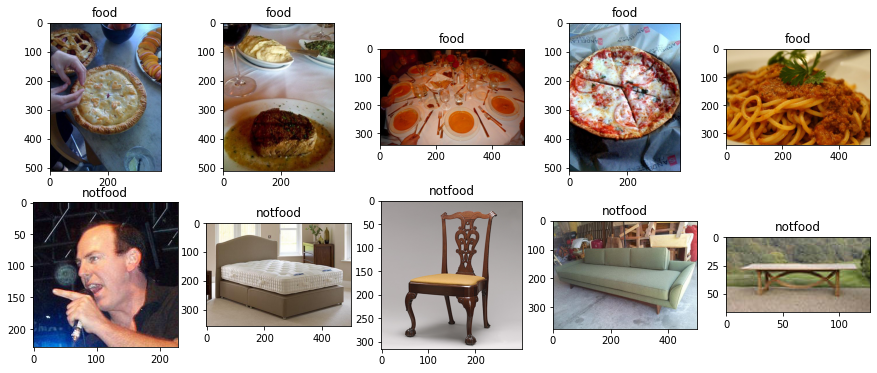

In [ ]:
# preview 5 images of each class
classes = ['food', 'notfood']
train_classes = [food,notfood]
nr = 5 #show 5 images from every class

classes_number = len(classes)
fig, axes = plt.subplots(classes_number,nr,figsize=(15,6))

for i in range(classes_number):
  for j in range(nr):
    axes[i, j].imshow(plt.imread(train_classes[i][j*210]))#show every 210th image of every class
    axes[i, j].set_title(classes[i])

Se poate observa ca fotografiile sunt diferite din punct de vedere al calitatii lor. Astfel, unele imagini sunt suprinse in lumina nefavorabila, si au dimensiuni, fundaluri si zgomot de imagine cu intensitati diferite.

## **Data Augmentation**

Marirea datelor formate din imagini reprezinta o tehnica folosita in invatarea profunda pentru a extinde in mod artificial setul de date folosit pentru antrenarea modelului. Prin aceasta tehnica sunt create versiuni (copii) ale imaginilor originale, dar cu mici modificari, fiind afectate de diferiti factori.

Datorita acestui proces se obtine o crestere a performantei modelului si a abilitatii sale de a generaliza. Astfel, se evita memorarea imaginilor si sunt invatate tipare.

Acest proces creeaza noi imagini care ofera senzatia de captura din diferite unghiuri a unui obict 3D(tridimensional) - ofera senzatie de intelegere 3D a obiectului

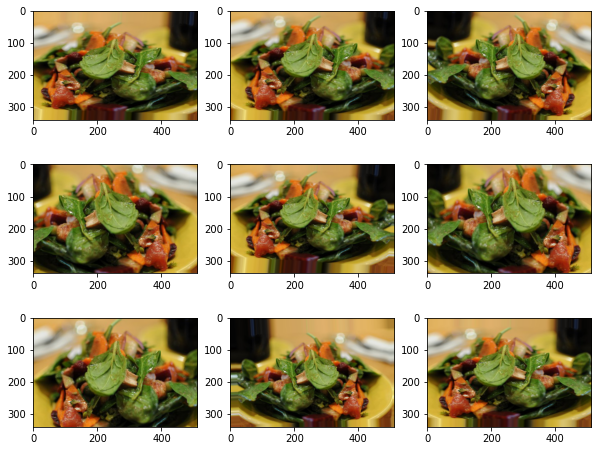

In [ ]:
# example of one image after image augmentation
# load the image
img = load_img(food[50])
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(img, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(featurewise_center=False,
              samplewise_center=False,
              featurewise_std_normalization=False,
              samplewise_std_normalization=False,
              zca_whitening=False,
              rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
              width_shift_range=0.05, #randomly shift images horizontally(percentage of total width)
              height_shift_range=0.05, #randomly shift images vertically(percentage of total height)
              shear_range=0.2,
              zoom_range=0.2,
              channel_shift_range=0.,
              fill_mode='nearest',
              cval=0.,
              horizontal_flip=True, #flip images horizontally but not vertically
              vertical_flip=False) #food can't stay upside down on the plate or table.
# prepare iterator #just flow because it is not from directory, it's just an image sample
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
fig, axes = plt.subplots(3,3,figsize=(10,8))
for i in range(3):
  for j in range(3):
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    axes[i,j].imshow(image)
# show the figure
plt.show()

Marirea intregului set de date:

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (% of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (% of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True, #flip images horizontally but not vertically 
                 vertical_flip=False, #because food can't stay upside down on the plate or table
                 rescale=1/255) #normalize image, add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory( #images are loaded in alphabetical order and 
                                                    #assigned an integer for each class 
        train_path,
        target_size=(224,224),
        class_mode='binary',
        batch_size=16)
test_datagen = ImageDataGenerator(rescale=1/255) # just normalize for testing set
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        class_mode='binary',
        batch_size=16)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


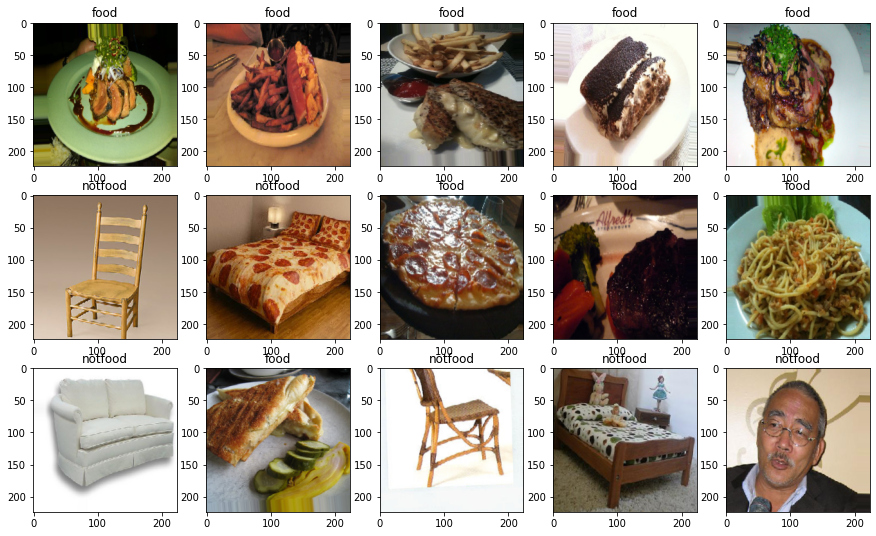

In [ ]:
# preview images from train generator
r = 3; c = 5
n=0
classtolabel = {'0':'food','1':'notfood'} #alphabetical order, each class assigned an integer 
                                          #because of flow_from_directory() function
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(15,9))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = x[1][n].astype('int').astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

## **Modelare**

Antrenarea modelului va fi facuta prin tehnica transfer learning. Astfel, setul de date si durata necesara pentru antrenare pot fi mai mici. Modelul de baza peste care se aplica noile cunostinte este modelul Keras VGG16. Acest model a fost antrenat pe setul de date Imagenet.

In [ ]:
nclass = len(train_generator.class_indices)
base_model = VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

Clasificarea binara presupune folosirea unei pierderi (loss) la compilarea modelului numita binary corss-entropy, folosirea unei functii "sigmoid" pentru activare si un singur neuron pe stratul de iesire (probabilitatea ca imaginea analizata sa contina sau nu clasa cautata).

In [ ]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.2),#dropout 20% of data to avoid memorization 
  #1 neuron on last layer because I use binary classification(it contains or not the searched class)
  #sigmoid activation for last layer on binary classification because it outputs probability and is 
  #good for binary mutually exclusive(food or not food)
  Dense(1, activation = "sigmoid",kernel_initializer='he_normal',kernel_regularizer=l2())])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#callbacks
checkpointer =ModelCheckpoint(filepath='modelVGG16BinaryClassificationFoodOrNotfood.hdf5',verbose=1, 
                              save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

#binary cross-entropy for loss because the model does a binary classification (it is food or not)
model.compile(optimizer = 'rmsprop' , loss = "binary_crossentropy", metrics=["accuracy"])

Antrenare pentru 100 epoci.

In [ ]:
batch_size = 16
history = model.fit(train_generator,steps_per_epoch=train_total/batch_size,
                              validation_data=test_generator,validation_steps=test_total/batch_size, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/100
125/125 [==============================] - 573s 4s/step - loss: 0.6241 - accuracy: 0.6974 - val_loss: 0.3900 - val_accuracy: 0.9180

Epoch 00001: val_loss improved from inf to 0.39001, saving model to modelVGG16BinaryClassificationFoodOrNotfood.hdf5
Epoch 2/100
125/125 [==============================] - 32s 259ms/step - loss: 0.3892 - accuracy: 0.9153 - val_loss: 0.2958 - val_accuracy: 0.9380

Epoch 00002: val_loss improved from 0.39001 to 0.29575, saving model to modelVGG16BinaryClassificationFoodOrNotfood.hdf5
Epoch 3/100
125/125 [==============================] - 33s 263ms/step - loss: 0.3047 - accuracy: 0.9408 - val_loss: 0.2633 - val_accuracy: 0.9520

Epoch 00003: val_loss improved from 0.29575 to 0.26331, saving model to modelVGG16BinaryClassificationFoodOrNotfood.hdf5
Epoch 4/100
125/125 [==============================] - 34s 270ms/step - loss: 0.2892 - accuracy: 0.9496 - val_loss: 0.2488 - val_accuracy: 0.9560

Epoch 00004: val_loss improved from 0.26331 to 0.24879,

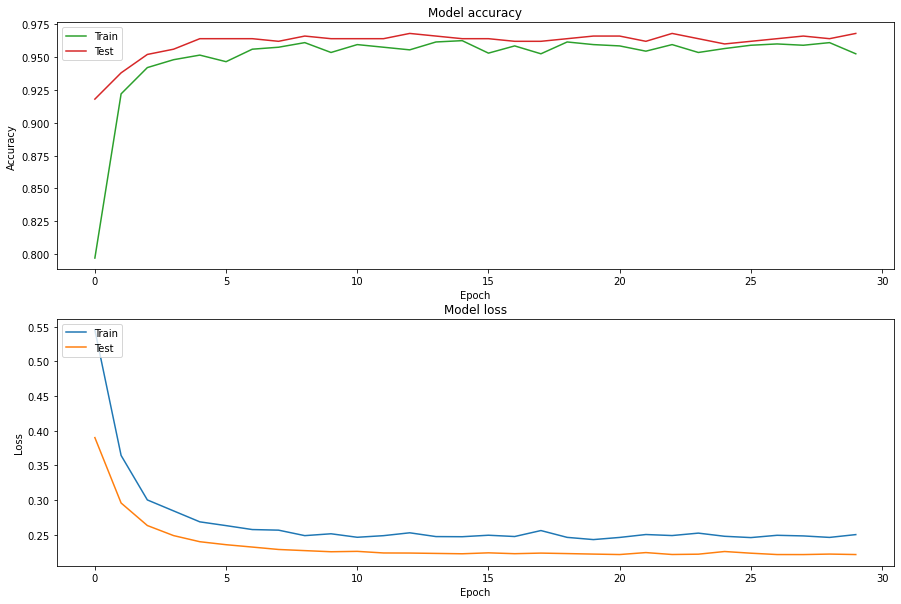

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

## **Evaluarea rezultatelor**

In [ ]:
# create another generator for all test images in a single batch
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=test_total)

Found 500 images belonging to 2 classes.


**Predictii**

Incarcarea modelului salvat

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/modelBinaryClassificationFoodOrNotfood-VGG16.h5"
model = load_model(export_path_keras)

Procentul de acuratete al modelului antrenat: 96,8%

In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilitie between 0 and 1, where closer to 0 is food 
                                    #and closer to 1 is not food
mythreshold = 0.5
y_pred = list(np.concatenate((y_pred_conf>=mythreshold).astype(int)).flat)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 96.8%


Verificarea a 10 predictii la intamplare

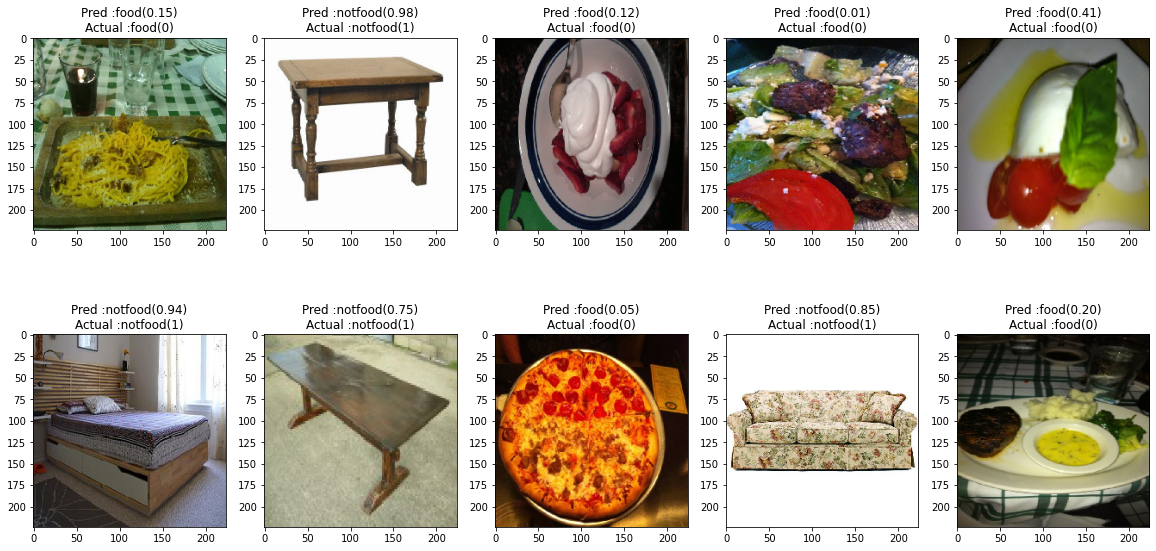

In [ ]:
classtolabel = {'0':'food','1':'notfood'} #alphabetical order, each class assigned an integer 
                                          #because of flow_from_directory() function
f, ax=plt.subplots(2,5,figsize=(20,10))
for k in range(2):
  for l in range(5):
      j=np.random.randint(1,len(x_test))
      ax[k,l].imshow(x_test[j])
      ax[k,l].set_title("Pred :{}({:.2f})\nActual :{}({})".format
                            (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                            classtolabel[str(y_label[j])],np.max((y_pred_conf[j] 
                            if y_pred[j]==y_label[j] else 1-y_pred_conf[j]).round().astype(int)),
                            fontweight="bold", size=20))

## **Matricea confuziilor**

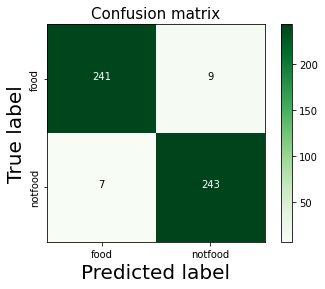

In [ ]:
def plot_confusion_matrix(cm):    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['food', 'notfood'] 
    plt.xticks([i for i in range(len(classes))], classes, fontsize=10)
    plt.yticks([i for i in range(len(classes))], classes, fontsize=10,rotation=90,
               verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" 
                     if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

Verificarea predictiilor eronate

In [ ]:
# find the wrong labels
def show_wrong_label(x_test,y_test,y_pred_conf):
    y_pred = np.array(list(np.concatenate((y_pred_conf>=mythreshold).astype(int)).flat))
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong y_pred (between 0 and 1)

    y_pred_classes_errors = y_pred[errors] # the wrong prediction label
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predictions

    img_errors = x_test[errors] # every image that has errors

    def display_errors(img_errors,pred_errors,y_pred_errors_prob):
        n = 0
        nrows = 4
        ncols = 4
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                  error = n
                  ax[row,col].imshow((img_errors[error]))
                  ax[row,col].set_title("Pred :{}({:.2f})".format
                                        (classtolabel[pred_errors[error].astype('str')],
                                        y_pred_errors_prob[error],
                                        fontweight="bold", size=20))
                  n += 1

    display_errors(img_errors, y_pred_classes_errors,y_pred_errors_prob)

In [ ]:
show_wrong_label(x_test,y_test,y_pred_conf)

Output hidden; open in https://colab.research.google.com to view.

## **Salvarea modelului**

Voi salva modelul sub formatul de fisier HDF5 specific Keras. Fisierul HDF5 va avea extensia .h5

In [ ]:
path = "/content/drive/MyDrive/Colab Projects/modelBinaryClassificationFoodOrNotfood-VGG16.h5"
export_path_keras = path
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/Colab Projects/modelBinaryClassificationFoodOrNotfood-VGG16.h5


Incarcarea modelului salvat

In [ ]:
path = "/content/drive/MyDrive/Colab Projects/modelBinaryClassificationFoodOrNotfood-VGG16.h5"
export_path_keras = path
reloaded = load_model(export_path_keras)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## **Predictia unei singure imagini**

Imaginea va fi incarcata din Google Drive

array([[0.70088816]], dtype=float32)

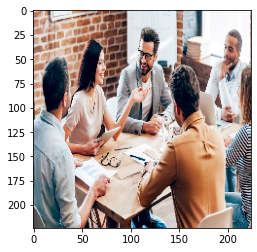

In [ ]:
img=load_img('/content/drive/MyDrive/Colab Projects/Test_images_from_google/why-employees-value-flexible-working_370390046.jpg',target_size=(224,224))
plt.imshow(img)
img = np.array(img).astype('float32')/255
img = np.expand_dims(img, axis=0)
reloaded.predict(img)

In [ ]:
classtolabel = {'0':'food','1':'notfood'}
result = reloaded.predict(img)
y_pred = (result[0][0].round()).astype(int)
print(classtolabel[str(y_pred)])

notfood
